# I. Mô tả bài toán


## 1.1. Tổng quan bài toán


**Book Genre Prediction**

*   Link: https://www.kaggle.com/datasets/athu1105/book-genre-prediction/data
*   Bộ dữ liệu "Book Genre Prediction" cung cấp thông tin tóm tắt nội dung của các tựa sách và phân loại chúng ra các chủ để liên quan.
*   Với tập dữ liệu này, bài toán phân loại "thể loại sách" (genre) được thực hiện bằng cách sử dụng các mô hình Học máy dựa trên nội dung tóm tắt của sách (summary)

## 1.2. Tổng quan cách triển khai



**1.   Khám phá dữ liệu**

*   Tổng quan về tập dữ liệu
*   Phân tích sự phân bổ của các nhãn và phân bổ từ trong mẫu
*   Phân tích từ dừng (stop words), các từ khóa chính trong mỗi nhãn thông qua phương pháp TF-IDF và N-grams
*   Từ đó, vẽ ma trận tương đồng để thấy sự tương quan nội dung giữa các nhãn

**2.   Chuẩn bị dữ liệu cho mô hình training**

*   Xóa các cột không cần thiết
*   Kiểm tra và xử lý dữ liệu thiếu
*   Kiểm tra và xử lý (xóa) có dòng bị trùng
*   Xóa các ký tự lạ + từ dừng (stop word) + ngoại lê (outlier) không có giá trị trong việc dự đoán
*   Chia tập dữ liệu train - test để đảm bảo không bị leak data khi huấn luyện mô hình
*   Thực hiện vecto hóa TF-IDF và endcoding để biến đổi dữ liệu phù hợp với mô hình huấn luyện

**3.   Xây dựng mô hình**

*   Mô hình Logistic Regression kết hợp Tuning
*   Mô hình Random Forest kết hợp Tuning
*   Mô hình SVM (LinearSVC) kết hợp Tuning

# II. Khám phá dữ liệu (EDA)

## 2.1. Nạp dữ liệu

In [ ]:
# ---Import Lib---
import numpy as np
import pandas as pd
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

In [ ]:
# ---Load Data---
url = 'https://raw.githubusercontent.com/nltnh/Python-Project/refs/heads/main/Text_Data/Book_Genre_Dataset2.csv'
df = pd.read_csv(url)

## 2.2. Tổng quan tập dữ liệu

In [ ]:
# ---Dataset Overview---
total_book = df.shape[0]
total_genre = df['genre'].nunique()
avg_words_per_book = df['summary'].apply(lambda x: len(str(x).split())).mean()
avg_chars_per_book = df['summary'].apply(lambda x: len(str(x).replace(" ",""))).mean()

# Creating overview_df
overview_df = pd.DataFrame({
    'Total Books': [total_book],
    'Genres': [total_genre],
    'Avg Words/book': [avg_words_per_book],
    'Avg Chars/book': [avg_chars_per_book]
})

# Formatting displayed values
overview_df = overview_df.round(0).astype(int)

print('\033[1mDataset Overview:\033[0m\n')
display(overview_df)
print('\033[1mNote:\033[0m Dont count space in chars')


# ---Dataset Example---
print('\n\n\033[1mDataset sample:\033[0m')
display(df.head())


Dataset Overview:



,Total Books,Genres,Avg Words/book,Avg Chars/book
0,2047,5,399,1954


Note: Dont count space in chars


Dataset sample:


,index,title,genre,summary
0,500,Starcross,science,"Protagonist Arthur (""Art"") Mumby and his olde..."
1,501,Glasshouse,science,It is the 27th century. The culture featured ...
2,502,Rocheworld,science,"In Rocheworld, a small group of civilian and ..."
3,503,Master of the Void,science,"In the post-war galaxy, ruined civilizations ..."
4,504,Vulcan's Hammer,science,"In 2029 CE, the Earth is run by the Unity org..."


## 2.3. Sự phân bổ của các nhãn

In [ ]:
# ---Category Distribution---

# Counting number of each label
genre_count = df['genre'].value_counts().sort_values(ascending=False)

# Changing numberical label to category name
#label_map = dict(zip(cat_df['genre'], cat_df['Category']))
#cat_count.index = cat_count.index.map(label_map)

genre_count_pie = go.Figure(go.Pie(
    labels = genre_count.index,
    values = genre_count.values,
    marker = dict(colors=['lightyellow', 'lightpink', 'lightskyblue', 'plum', 'lightgreen', '#D8BFD8', '#FFDAB9', '#F0E68C', '#B0E0E6', '#C1E1C1']),
    textinfo = 'label+value+percent',
    textfont_size = 13
))

# Creating pie chart
genre_count_pie.update_layout(
    title = '<b>Genre Distribution<b>',
    width = 800,
    showlegend = True
)
genre_count_pie.show()


Các nhãn phân bổ không đều, khó học các nhãn hiếm:

*   3 nhãn history, science, horror phân bổ lần lượt 29.3%, 31.6%, 29.3%
*   2 nhãn còn lại travel và sports chỉ chiếm 4.89% và 4.89% trong toàn tập dữ liệu



## 2.4. Phân tích từ dừng (Stop word)

In [ ]:
stop_words = set(ENGLISH_STOP_WORDS)

news_stopwords = ['said', 'mr', 'ms', 'mrs', 'told', 'says', 'say', 'according', 'year', 'years', 'new', 'old', 'like', 'just', 'going', 'got', 'use', 'used', 'make', 'made']
stop_words.update(news_stopwords)

all_words = ' '.join(df['summary']).split()
stop_word_counts = Counter([w for w in all_words if w in stop_words])
top_stop_words = stop_word_counts.most_common(20)

words = [w for w, count in top_stop_words]
counts = [count for w, count in top_stop_words]

fig = go.Figure(data=[go.Bar(
    x=words,
    y=counts,
    marker_color='lightgreen',
    text=counts,
    textposition='outside'
)])

fig.update_layout(
    title='<b>Top 20 Stop Words<b>',
    xaxis_title='Stop Words',
    yaxis_title='Frequency',
    width=900,
    height=400,
    showlegend=False
)

fig.show()

# Statistics
total_words = len(all_words)
total_stop_words = sum(stop_word_counts.values())
print(f"Total words: {total_words:,}")
print(f"Stop words: {total_stop_words:,} ({total_stop_words/total_words*100:.1f}%)")
print(f"Unique stop words found: {len(stop_word_counts)}")


Total words: 817,493
Stop words: 371,844 (45.5%)
Unique stop words found: 312


## 2.5. Sự phân bổ từ (Word Count Distrinution)

In [ ]:
# Calculate word counts
df['word_count'] = df['summary'].str.split().str.len()

# Create histogram bins
bins = np.arange(0, df['word_count'].max() + 100, 100)
hist, bin_edges = np.histogram(df['word_count'], bins=bins)

# Format bin labels
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(hist))]

# Create histogram
fig = go.Figure(data=[go.Bar(
    x=bin_labels,
    y=hist,
    marker_color='#667eea',
    text=hist,
    textposition='outside'
)])

fig.update_layout(
    title='Word Count Distribution',
    xaxis_title='Word Count Ranges',
    yaxis_title='Number of Articles',
    width=1500,
    height=600,
    showlegend=False,
    xaxis={'tickangle': 45}
)

fig.show()

# Print statistics
print(f"Mean: {df['word_count'].mean():.2f}")
print(f"Median: {df['word_count'].median():.2f}")
print(f"Min: {df['word_count'].min()}")
print(f"Max: {df['word_count'].max()}")
print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {df['word_count'].quantile(p/100):.0f}")

Mean: 399.36
Median: 226.00
Min: 1
Max: 5663

Percentiles:
  25th: 119
  50th: 226
  75th: 523
  90th: 926
  95th: 1207
  99th: 2283


## 2.6. Số lượng từ trong mỗi nhãn (Vocabulary Richness by Genre)

In [ ]:
# ---Vocabulary Richness by Category---
genres = df['genre'].unique()

vocab_list = []
for genre in genres:
    genre_df = df[df['genre'] == genre]
    text = " ".join(genre_df['summary'])
    tokens = re.findall(r'\b[a-z]{3,}\b', text)
    tokens = [t for t in tokens if t not in stop_words]
    total_words = len(tokens)
    unique_words = len(set(tokens))
    ttr = unique_words / total_words if total_words > 0 else 0
    vocab_list.append({
        'Genre': genre,
        'Total_Words': total_words,
        'Unique_Words': unique_words,
        'TTR': round(ttr, 4),
        'Samples': len(genre_df)
    })


vocab_df = pd.DataFrame(vocab_list).sort_values(by='Unique_Words', ascending=False)

# ---Vẽ biểu đồ---
fig = go.Figure()

fig.add_trace(go.Bar(
    x=vocab_df['Genre'],
    y=vocab_df['Unique_Words'],
    marker_color=['#6EC1E4', '#A1DE93', '#FFD275', '#FF9A76', '#C492B1',
                  '#8AC4D0', '#E5B181', '#A0BCC2', '#FFB7B2', '#B4C6A6'],
    text=vocab_df['TTR'],
    textposition='outside',
    name='Unique Words'
))

fig.update_layout(
    title='<b>Vocabulary Richness by Genre</b>',
    xaxis_title='Genre',
    yaxis_title='Unique Words Count',
    plot_bgcolor='aliceblue',
    width=850,
    height=450
)

fig.show()

# ---Hiển thị bảng kết quả---
print("Vocabulary Richness Statistics (by Genre):")
print(vocab_df.to_string(index=False))


Vocabulary Richness Statistics (by Genre):
  Genre  Total_Words  Unique_Words    TTR  Samples
science        92270         14813 0.1605      647
history        99995         14608 0.1461      600
 horror        95550         13543 0.1417      600
 travel         6449          3286 0.5095      100
 sports         7154          2768 0.3869      100


## 2.7. Các từ khóa chính (Top 20 words by genre)

In [ ]:
genre_list = ['science', 'history', 'horror', 'travel', 'sports']

def top_words():
  for cate in genre_list:
    cat_df = df[df['genre'] == cate]

    all_text = ' '.join(cat_df['summary']).lower()
    # Use regex to match words >= 3 characters (same as report)
    words = re.findall(r'[a-z]{3,}', all_text)
    words = [w for w in words if w not in stop_words]
    word_counts = Counter(words).most_common(20)

    words_list = [word for word, count in word_counts]
    counts_list = [count for word, count in word_counts]

    # Create horizontal bar chart
    fig = go.Figure(data=[go.Bar(
        x=counts_list,
        y=words_list,
        orientation='h',
        marker_color='#FF9A76',
        text=counts_list,
        textposition='outside'
    )])

    fig.update_layout(
        title=f'Top 20 Words in {cate.capitalize()} Books',
        xaxis_title='Frequency',
        yaxis_title='Words',
        width=800,
        height=600,
        yaxis={'autorange': 'reversed'}  # Top word at top
    )

    fig.show()

    #Print statistics
    print(f"\nTop words in {cate}:")
    for word, count in word_counts[:10]:
        print(f"  {word:15s}: {count:4d}")

top_words()


Top words in science:
  time           :  670
  world          :  498
  earth          :  479
  planet         :  430
  ship           :  416
  human          :  398
  life           :  360
  war            :  310
  people         :  307
  space          :  291



Top words in history:
  father         :  582
  time           :  433
  king           :  409
  life           :  396
  family         :  388
  war            :  381
  story          :  381
  mother         :  356
  novel          :  353
  french         :  345



Top words in horror:
  anita          :  541
  house          :  456
  man            :  397
  life           :  389
  time           :  360
  vampire        :  352
  night          :  344
  story          :  333
  world          :  322
  father         :  320



Top words in travel:
  world          :   68
  travel         :   62
  life           :   55
  journey        :   45
  people         :   41
  book           :   37
  time           :   34
  city           :   33
  country        :   28
  way            :   27



Top words in sports:
  team           :   73
  life           :   59
  hockey         :   56
  time           :   37
  love           :   36
  player         :   35
  doesn          :   35
  game           :   34
  world          :   33
  star           :   31


## 2.8. Top từ khóa TF-IDF (TF-IDF Top Terms by Category)

In [ ]:
genre_list = ['science', 'history', 'horror', 'travel', 'sports']

def top_tfidf():
  for cate in genre_list:
    # Calculate TF-IDF on ALL documents in dataset (same as report)
    vectorizer = TfidfVectorizer(max_features=5000, stop_words=list(stop_words))
    tfidf_matrix = vectorizer.fit_transform(df['summary'])
    feature_names = vectorizer.get_feature_names_out()

    # Get indices of documents in selected category
    cat_indices = df[df['genre'] == cate].index

    # Get TF-IDF scores for documents in this category
    cat_tfidf = tfidf_matrix[cat_indices]

    # Calculate MEAN TF-IDF score for each term (same as report)
    mean_scores = np.array(cat_tfidf.mean(axis=0)).flatten()

    # Get top 20 terms
    top_indices = mean_scores.argsort()[-20:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = [mean_scores[i] for i in top_indices]

    # Create horizontal bar chart
    fig = go.Figure(data=[go.Bar(
        x=top_scores,
        y=top_words,
        orientation='h',
        marker_color='#6EC1E4',
        text=[f'{score:.4f}' for score in top_scores],
        textposition='outside'
    )])

    fig.update_layout(
        title=f'Top 20 TF-IDF Terms in {cate.capitalize()}',
        xaxis_title='TF-IDF Score',
        yaxis_title='Terms',
        width=800,
        height=600,
        yaxis={'autorange': 'reversed'}
    )

    fig.show()

    # Print top terms
    print(f"\nTop TF-IDF terms in {cate}:")
    for word, score in zip(top_words[:10], top_scores[:10]):
        print(f"  {word:20s}: {score:.4f}")

top_tfidf()


Top TF-IDF terms in science:
  planet              : 0.0299
  earth               : 0.0291
  world               : 0.0259
  time                : 0.0242
  human               : 0.0229
  space               : 0.0215
  novel               : 0.0199
  war                 : 0.0177
  future              : 0.0171
  science             : 0.0169



Top TF-IDF terms in history:
  war                 : 0.0245
  father              : 0.0216
  story               : 0.0212
  king                : 0.0207
  novel               : 0.0200
  book                : 0.0186
  history             : 0.0178
  family              : 0.0178
  life                : 0.0170
  french              : 0.0164



Top TF-IDF terms in horror:
  buffy               : 0.0226
  vampire             : 0.0206
  angel               : 0.0193
  house               : 0.0188
  town                : 0.0176
  anita               : 0.0173
  story               : 0.0168
  man                 : 0.0167
  novel               : 0.0165
  world               : 0.0153



Top TF-IDF terms in travel:
  travel              : 0.0575
  journey             : 0.0440
  world               : 0.0401
  theroux             : 0.0366
  life                : 0.0318
  bryson              : 0.0303
  country             : 0.0296
  people              : 0.0270
  city                : 0.0243
  account             : 0.0239



Top TF-IDF terms in sports:
  hockey              : 0.0691
  team                : 0.0587
  football            : 0.0386
  neil                : 0.0369
  player              : 0.0359
  game                : 0.0348
  baseball            : 0.0309
  doesn               : 0.0302
  life                : 0.0302
  sports              : 0.0301


## 2.9. Top từ khóa N-grams (N-grams Analysis)

In [ ]:
genre_list = ['science', 'history', 'horror', 'travel', 'sports']

def top_ngrams():
  for cate in genre_list:
    cat_df = df[df['genre'] == cate]
    # Combine all articles in category into ONE text (same as report)
    combined_text = ' '.join(cat_df['summary'].values)

    # Extract bigrams using TF-IDF on the combined text
    vectorizer = TfidfVectorizer(
        ngram_range=(2, 2),  # Bigrams only
        max_features=50,
        stop_words=list(stop_words)
    )
    # Fit on single combined text (returns 1 row)
    tfidf_matrix = vectorizer.fit_transform([combined_text])

    # Get TF-IDF scores (single row, so no need for mean)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]

    # Get top 15 bigrams
    top_indices = tfidf_scores.argsort()[-15:][::-1]
    top_bigrams = [feature_names[i] for i in top_indices]
    top_scores = [tfidf_scores[i] for i in top_indices]

    # Create horizontal bar chart
    fig = go.Figure(data=[go.Bar(
        x=top_scores,
        y=top_bigrams,
        orientation='h',
        marker_color='#4facfe',
        text=[f'{score:.4f}' for score in top_scores],
        textposition='outside'
    )])

    fig.update_layout(
        title=f'Top 15 Bigrams in {cate.capitalize()} (TF-IDF)',
        xaxis_title='TF-IDF Score',
        yaxis_title='Bigrams',
        width=900,
        height=600,
        yaxis={'autorange': 'reversed'}
    )

    fig.show()

    # Print results
    print(f"\nTop bigrams in {cate}:")
    for bigram, score in zip(top_bigrams[:10], top_scores[:10]):
        print(f"  {bigram:25s}: {score:.4f}")

top_ngrams()


Top bigrams in science:
  yuuzhan vong             : 0.3559
  united states            : 0.3001
  takes place              : 0.2791
  time traveller           : 0.2163
  yeerk pool               : 0.1954
  obi wan                  : 0.1954
  science fiction          : 0.1884
  human race               : 0.1535
  artificial intelligence  : 0.1535
  time travel              : 0.1465



Top bigrams in history:
  civil war                : 0.2981
  falls love               : 0.2859
  world war                : 0.2616
  sir john                 : 0.2555
  takes place              : 0.2068
  united states            : 0.1947
  ben hur                  : 0.1947
  priya duryodhani         : 0.1886
  story begins             : 0.1886
  scarlet pimpernel        : 0.1764



Top bigrams in horror:
  jean claude              : 0.7242
  takes place              : 0.2056
  lord loss                : 0.1682
  man named                : 0.1542
  young man                : 0.1402
  los angeles              : 0.1355
  ka tet                   : 0.1308
  young woman              : 0.1262
  high school              : 0.1262
  serial killer            : 0.1262



Top bigrams in travel:
  paul theroux             : 0.3293
  silk road                : 0.2195
  lost city                : 0.2195
  book description         : 0.2195
  anthony bourdain         : 0.1829
  frances mayes            : 0.1829
  travel writer            : 0.1829
  tuscan sun               : 0.1829
  travel writing           : 0.1829
  york times               : 0.1464



Top bigrams in sports:
  york times               : 0.2661
  hockey team              : 0.2661
  hockey player            : 0.2395
  high school              : 0.2395
  hockey star              : 0.2129
  hockey players           : 0.2129
  bestselling author       : 0.2129
  dream team               : 0.1863
  carolina cold            : 0.1863
  cold fury                : 0.1863


## 2.10. Ma trận tương đồng

In [ ]:
categories = sorted(df['genre'].unique())
vectorizer = TfidfVectorizer(max_features=5000, stop_words=list(stop_words))
tfidf_matrix = vectorizer.fit_transform(df['summary'])

# Calculate mean similarity between each pair of categories
n_cats = len(categories)
similarity_matrix = np.zeros((n_cats, n_cats))

for i, cat1 in enumerate(categories):
    cat1_indices = df[df['genre'] == cat1].index
    cat1_vectors = tfidf_matrix[cat1_indices]

    for j, cat2 in enumerate(categories):
        cat2_indices = df[df['genre'] == cat2].index
        cat2_vectors = tfidf_matrix[cat2_indices]

        # Compute pairwise similarities between all document pairs
        pairwise_sim = cosine_similarity(cat1_vectors, cat2_vectors)

        # Take mean similarity (this is why diagonal != 1.0)
        similarity_matrix[i, j] = np.mean(pairwise_sim)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=similarity_matrix,
    x=categories,
    y=categories,
    colorscale='Purples',
    text=similarity_matrix,
    texttemplate='%{text:.3f}',
    textfont={"size": 12},
    colorbar=dict(title="Similarity")
))

fig.update_layout(
    title='Category Similarity Matrix (Cosine Similarity)',
    xaxis_title='genre',
    yaxis_title='genre',
    width=700,
    height=600,
    yaxis={'autorange': 'reversed'}
)

fig.show()

# Print similarity matrix
print("\nCategory Similarity Matrix:")
print("Note: Diagonal is NOT 1.0 because it's MEAN similarity between documents")
print("within same category, not self-similarity\n")

for i, cat1 in enumerate(categories):
    print(f"{cat1:15s}: {similarity_matrix[i][i]:.3f} (within-category)")
    for j, cat2 in enumerate(categories):
        if i < j:  # Cross-category only
            sim = similarity_matrix[i][j]
            status = "⚠️ High" if sim > 0.02 else "✓ Low"
            print(f"  vs {cat2:15s}: {sim:.3f} {status}")

# 1: cùng loại (perfect match)
# 0.45 - 0.8: độ tương đồng cao (dễ nhầm lẫn)
# 0.15 - 0.45: độ tương đồng trung bình, chấp nhận đc
# 0 - 0.15: tương đồng thấp (dễ phân biệt)


Category Similarity Matrix:
Note: Diagonal is NOT 1.0 because it's MEAN similarity between documents
within same category, not self-similarity

history        : 0.027 (within-category)
  vs horror         : 0.016 ✓ Low
  vs science        : 0.017 ✓ Low
  vs sports         : 0.015 ✓ Low
  vs travel         : 0.018 ✓ Low
horror         : 0.023 (within-category)
  vs science        : 0.015 ✓ Low
  vs sports         : 0.015 ✓ Low
  vs travel         : 0.014 ✓ Low
science        : 0.026 (within-category)
  vs sports         : 0.015 ✓ Low
  vs travel         : 0.017 ✓ Low
sports         : 0.061 (within-category)
  vs travel         : 0.018 ✓ Low
travel         : 0.048 (within-category)


# III. Chuẩn bị dữ liệu

## 3.1. Xóa các cột không cần thiết

In [ ]:
df = df[['summary', 'genre']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  2047 non-null   object
 1   genre    2047 non-null   object
dtypes: object(2)
memory usage: 32.1+ KB


## 3.2. Xóa các mẫu có 2 nhãn

In [ ]:
duplicates = df.groupby("summary")["genre"].nunique()
texts_to_remove = duplicates[duplicates > 1].index.tolist()

# Xóa các mẫu đó
df = df[~df["summary"].isin(texts_to_remove)]

## 3.3. Xử lý dữ liệu thiếu (Missing value)

In [ ]:
# ---Missing Data---

# Check missing data
missing_count = df.isnull().sum()
total_missing = missing_count.sum()

if total_missing == 0:
    print('\033[1mMissing Data:\033[0m No missing values')
else:
    missing_pct = (missing_count / len(df) * 100).round(2)
    print('\033[1mMissing Data (%):\033[0m')
    print(missing_pct[missing_percent > 0])

# Handle missing data (if any)

Missing Data: No missing values


## 3.4. Xử lý dữ liệu trùng (Duplicate value)

In [ ]:
# ---Duplicate Data---

# Check duplicate data
dup_count = df.duplicated().sum()
total_rows = len(df)

if dup_count == 0:
    print('\033[1mDuplicate Data:\033[0m No duplicate rows')
else:
    dup_pct = (dup_count/ total_rows * 100).round(2)
    print('\033[1mDuplicate Data:\033[0m')
    print(f'Duplicate rows: {dup_count}')
    print(f'% Duplicate: {dup_pct}%')

#Handle duplicate data (if any)
df = df.drop_duplicates()
print(df.info())

Duplicate Data:
Duplicate rows: 16
% Duplicate: 0.79%
<class 'pandas.core.frame.DataFrame'>
Index: 2008 entries, 0 to 2046
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  2008 non-null   object
 1   genre    2008 non-null   object
dtypes: object(2)
memory usage: 47.1+ KB
None


## 3.5. Xóa các ký tự lạ

In [ ]:
# ---Special char---
import re

# Check special char
all_text = ' '.join(df['summary'].astype(str))
total_chars = len(all_text)
spc_chars = re.findall(r'[^a-zA-Z0-9\s]', all_text)
spc_char_count = len(spc_chars)

if spc_char_count == 0:
    print('\033[1mSpecial Chars:\033[0m No special chars')
else:
    spc_char_pct = round(spc_char_count/ total_chars * 100, 2)

    print(f"Total chars: {total_chars}")
    print(f"Total specical chars: {spc_char_count}")
    print(f"% special chars: {spc_char_pct}%")

# Handle special char
def remove_spc_chars(text):

    text = str(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

df['summary'] = df['summary'].apply(remove_spc_chars)

#Check
#total_chars_new = len(' '.join(df['summary_clean'].astype(str)))
#print(total_chars_new)


Total chars: 4772435
Total specical chars: 125646
% special chars: 2.63%


## 3.6. Xóa từ dừng (Stop word) và ngoại lệ (Outlier)

In [ ]:
# Xóa stop word và outlier
df['word_count'] = df['summary'].str.split().str.len()
Q1 = df['word_count'].quantile(0.25)
Q3 = df['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['word_count'] >= lower) & (df['word_count'] <= upper)].reset_index(drop=True)
print("After IQR filtering shape:", df.shape)

After IQR filtering shape: (1891, 3)


## 3.7. Chia tập dữ liệu train - test

In [ ]:
df_ml = df[['summary', 'genre']]

In [ ]:
# Chia tập dữ liệu train-test
X_text = df_ml['summary']   # cột text đã tiền xử lý
y_raw = df_ml['genre']

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

print('Done split train-test')

Done split train-test


## 3.8. Vecto hóa - TF-IDF

In [ ]:
# Vecto hóa - TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Tạo TF-IDF vectorizer, loại bỏ stop words tiếng Anh
tfidf = TfidfVectorizer(
    max_features=10000,      # số lượng từ đặc trưng tối đa
    ngram_range=(1,3),      # unigram + bigram
    stop_words='english'    # tự động loại stop words
)

# Fit trên tập train và transform
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform tập test
X_test_tfidf = tfidf.transform(X_test)


## 3.9. Encoding

In [ ]:
# Encoding lable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
class_names = le.classes_

# IV. Huấn luyện mô hình

## 4.1. Hyperparameter tuning: Logistic Regression

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga', 'lbfgs'],
    'max_iter': [1000, 2000]
}

grid_lr = GridSearchCV(
    LogisticRegression(multi_class='multinomial'),
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_lr.fit(X_train_tfidf, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

print("\n=== Logistic Regression (Tuned) ===")
print("Best params:", grid_lr.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=class_names))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.




=== Logistic Regression (Tuned) ===
Best params: {'C': 10, 'max_iter': 1000, 'solver': 'saga'}
Accuracy: 0.7889182058047494
              precision    recall  f1-score   support

     history       0.73      0.86      0.79       109
      horror       0.78      0.82      0.80       112
     science       0.84      0.79      0.82       121
      sports       1.00      0.59      0.74        17
      travel       0.88      0.35      0.50        20

    accuracy                           0.79       379
   macro avg       0.85      0.68      0.73       379
weighted avg       0.80      0.79      0.78       379



## 4.2. Hyperparameter tuning: Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train_tfidf, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_tfidf)

print("\n=== Random Forest (Tuned) ===")
print("Best params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=class_names))


=== Random Forest (Tuned) ===
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.7704485488126649
              precision    recall  f1-score   support

     history       0.72      0.80      0.76       109
      horror       0.76      0.84      0.80       112
     science       0.80      0.81      0.81       121
      sports       1.00      0.53      0.69        17
      travel       1.00      0.20      0.33        20

    accuracy                           0.77       379
   macro avg       0.86      0.64      0.68       379
weighted avg       0.79      0.77      0.76       379



## 4.3. Hyperparameter tuning: SVM (LinearSVC)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    'C': [1, 5, 10, 20, 50],
    'max_iter':[1000, 5000]
}

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_svm.fit(X_train_tfidf, y_train)

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_tfidf)

print("\n=== SVM (LinearSVC Tuned) ===")
print("Best params:", grid_svm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=class_names))



=== SVM (LinearSVC Tuned) ===
Best params: {'C': 1, 'max_iter': 1000}
Accuracy: 0.8153034300791556
              precision    recall  f1-score   support

     history       0.75      0.86      0.80       109
      horror       0.83      0.84      0.84       112
     science       0.84      0.79      0.81       121
      sports       1.00      0.71      0.83        17
      travel       0.93      0.70      0.80        20

    accuracy                           0.82       379
   macro avg       0.87      0.78      0.82       379
weighted avg       0.82      0.82      0.82       379



## 4.4. Đánh giá mô hình


=== Best Model: SVM (81.53%) ===


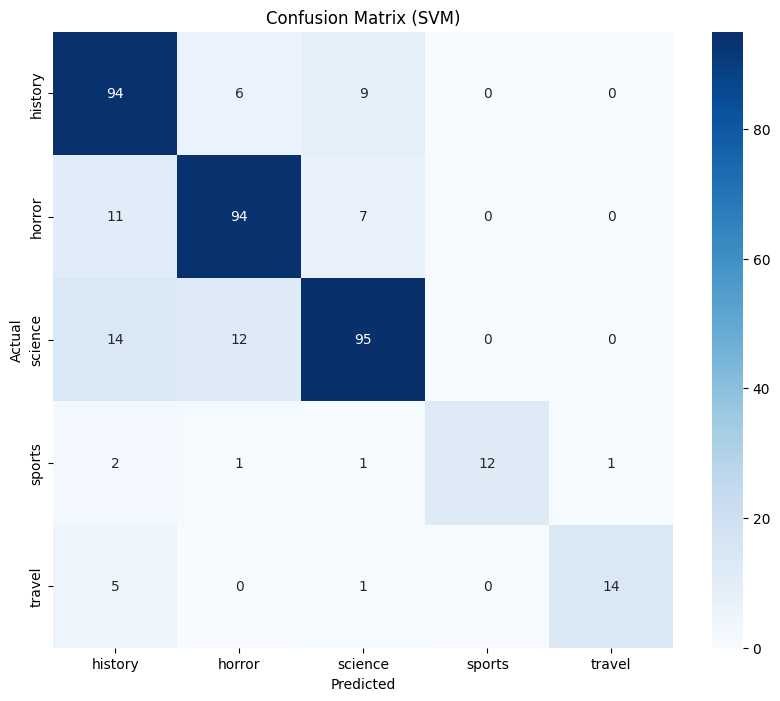

In [ ]:

# =========================================
# --- Chọn model tốt nhất ---
# =========================================
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_svm = accuracy_score(y_test, y_pred_svm)

best_pred = max([(y_pred_lr, acc_lr, "Logistic Regression"),
                 (y_pred_rf, acc_rf, "Random Forest"),
                 (y_pred_svm, acc_svm, "SVM")],
                key=lambda x: x[1])

best_pred_labels, best_acc, best_model_name = best_pred

print(f"\n=== Best Model: {best_model_name} ({best_acc*100:.2f}%) ===")


# =========================================
# --- Confusion Matrix ---
# =========================================
cm = confusion_matrix(y_test, best_pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix ({best_model_name})")
plt.show()


## 4.5. Mốt số phương pháp khác

BERT

In [ ]:
pip install transformers torch scikit-learn

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Giả sử df đã qua xử lý sạch: df['summary_clean'], df['genre']

# 1. Encode label nếu là string
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['genre'])

# 2. Chia train-test
X_train, X_test, y_train, y_test = train_test_split(
    df['summary'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# 3. Load tokenizer và model BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# 4. Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 5. Tạo DataLoader
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 6. Lấy embedding từ BERT
for batch in train_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']

    with torch.no_grad():
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        # Lấy pooled output CLS token cho classification
        embeddings = outputs.pooler_output
        print("Embedding shape:", embeddings.shape)  # (batch_size, hidden_size)
    break  # chỉ in batch đầu tiên để kiểm tra


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding shape: torch.Size([16, 768])


In [ ]:
pip install scikit-learn


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Tạo classifier đơn giản trên BERT
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # CLS embedding
        out = self.dropout(pooled_output)
        return self.fc(out)

num_classes = len(df['label'].unique())
model = BERTClassifier(bert_model, num_classes)
model.to(device)

# 2. Loss + Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# 3. Training loop (1 epoch demo)
for epoch in range(1):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 4. Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


Accuracy : 0.7205
Precision: 0.6927
Recall   : 0.7205
F1 Score : 0.6790


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Oversampling


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

# 3. Oversampling trên tập train
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

print("Original train class distribution:", pd.Series(y_train).value_counts())
print("Resampled train class distribution:", pd.Series(y_resampled).value_counts())

# 4. Train classifier (ví dụ Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_resampled, y_resampled)

# 5. Predict trên test set
y_pred = clf.predict(X_test_tfidf)

# 6. Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Original train class distribution: 2    483
1    448
0    436
4     78
3     67
Name: count, dtype: int64
Resampled train class distribution: 2    483
3    483
1    483
0    483
4    483
Name: count, dtype: int64
Accuracy : 0.8153
Precision: 0.8239
Recall   : 0.8153
F1 Score : 0.8163


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

# 4. Oversampling trên tập train
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

print("Original train class distribution:\n", pd.Series(y_train).value_counts())
print("Resampled train class distribution:\n", pd.Series(y_resampled).value_counts())

# 5. Train SVM classifier
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_resampled, y_resampled)

# 6. Predict trên test set
y_pred = svm_clf.predict(X_test_tfidf)

# 7. Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Original train class distribution:
 2    483
1    448
0    436
4     78
3     67
Name: count, dtype: int64
Resampled train class distribution:
 2    483
3    483
1    483
0    483
4    483
Name: count, dtype: int64
Accuracy : 0.8047
Precision: 0.8144
Recall   : 0.8047
F1 Score : 0.8021
